## Brief network description

We are working with an openflights airport network from icon.colorado.edu. which is a weighted, directed, multigraph, network where the nodes represent airports worldwide and the direction of edge {i,j} indicates a regularly occurring commercial flight, by a particular airline from airport i to airport j. Multiple edges may exist between pairs of airports if multiple airlines offer that flight, or if one airline offers multiple such flights each day. The  number of nodes is: 3214 and the  number of edges is: 18859.
https://networks.skewed.de/net/openflights


In [1]:
## Installs
!pip install networkx
!pip install powerlaw
!pip install python-louvain
!pip install python-igraph
!pip install shapely
!pip install geopy

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Imports

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import Counter
import powerlaw
import geopy.distance
import math
import statistics

# For the 
import folium
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from folium.plugins import HeatMap, MarkerCluster
from folium import plugins
import branca
import branca.colormap as cm

from community import community_louvain
#import matplotlib.cm as cm

## Reading in our data

In [3]:
nodes = '../network/nodes.csv'
edges = "../network/edges.csv"

pd_nodes = pd.read_csv(nodes, sep=",")
pd_edges = pd.read_csv(edges, sep=",")
pd_edges.columns 

Index(['# source', ' target', ' distance', ' airline', ' airline_code',
       ' codeshare', ' equipment', ' stops'],
      dtype='object')

In [4]:
G =nx.from_pandas_edgelist(pd_edges,source='# source', target=' target', create_using = nx.MultiDiGraph)
print(nx.info(G))

MultiDiGraph with 3214 nodes and 66771 edges


## Basic Network statistics - Exploratory data analysis

### Connected Components

In [5]:
print('Strongly connected components:', nx.number_strongly_connected_components(G))
print('Weakly connected components:', nx.number_weakly_connected_components(G))


Strongly connected components: 48
Weakly connected components: 7


### Isolated nodes

In [6]:
## Find isolated nodes:
Num_of_iso = 0
for i in nx.isolates(G):
    print(i)
    Num_of_iso += 1
print("There are", Num_of_iso, "isolated nodes")

There are 0 isolated nodes


### Self loops

In [7]:
#Find self loops
nx.number_of_selfloops(G)
for i in nx.selfloop_edges(G):
    print("There is one self loop which can be found at node:", i)

There is one self loop which can be found at node: (1931, 1931)


In [8]:
#The self loop
pd_edges[pd_edges["# source"]==1931]

,# source,target,distance,airline,airline_code,codeshare,equipment,stops
57358,1931,1930,352.862275,IL,10121,0,AT7,0
57359,1931,1589,673.949617,IL,10121,0,737,0
57360,1931,1590,214.215655,IL,10121,0,AT7 737,0
57361,1931,1931,0.000000,IL,10121,0,AT7,0
57362,1931,1942,544.646348,IL,10121,0,AT7,0
57363,1931,1925,495.988136,IL,10121,0,737 AT7,0
57364,1931,1941,534.399882,IL,10121,0,737,0


### Degree Distribution &amp; Cumulative Distribution Plots

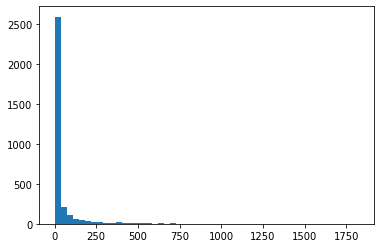

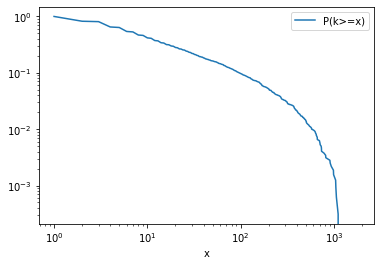

In [9]:
# Degree distribution plot
def plot_degree_dist(G):
    degrees = [(G.degree(n)) for n in G.nodes()]#np.log?
    plt.hist(degrees, 50)
    plt.show()

# The cumulative distribution plot (The y-axis in a CCDF is the probability of finding a node of degree k or high)
def plot_cum_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    num_of_nodes = len(degrees)
    count_degrees = Counter([G.degree(n) for n in G.nodes()])
    count_degrees = collections.OrderedDict(sorted(count_degrees.items()))
    cum_dict = {}
    node_count = 0
    for degree, times in count_degrees.items():
        node_count += times
        cum_dict[degree]= 1 - (node_count/num_of_nodes)
    data = pd.DataFrame(list(cum_dict.items()),columns = ['x','P(k>=x)'])
    data.plot(x = 'x',y = 'P(k>=x)', loglog = True)
    plt.show()

plot_degree_dist(G)
plot_cum_dist(G)

### Density

In [10]:
#Density of the graph (Using networkx)
dens = nx.density(G)
print('Networkx density:', str(round(dens*100, 3))+'%')

#Density using the formular (simple directed graph)
# total egdes / total nodes*(total nodes - 1)
dens_form = (G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes()-1))
print('Formular density:', str(round(dens_form*100, 3))+'%')

Networkx density: 0.647%
Formular density: 0.647%


### Global, local, average Clustering Coeffecients

In [11]:
#Here we are assuming that connection is all that matters, therefore digraph is used not multidigraph 
G_di = nx.DiGraph(G)
global_clustering = nx.transitivity(G_di)

# Local clustering
local_clustering = nx.clustering(G_di)

#Average clustering coefficient
avg_clustering = nx.average_clustering(G_di)

print("Global clustering:", global_clustering)
print("Average clustering:",avg_clustering)
print("Local clustering:",local_clustering)

Global clustering: 0.25005448521436646
Average clustering: 0.4782853255477227
Local clustering: {0: 1.0, 2: 0.390625, 3: 0.3888888888888889, 1: 0.5714285714285714, 4: 0.12298387096774194, 5: 0.8333333333333334, 2250: 0.7, 2256: 1.0, 2251: 1.0, 2254: 0.8333333333333334, 2253: 1.0, 2243: 0.6666666666666666, 2246: 1.0, 2245: 0.6666666666666666, 2255: 0.42857142857142855, 1610: 0.1276029434789416, 2244: 0.3333333333333333, 2247: 0.6666666666666666, 2241: 0.5, 2135: 0.15270935960591134, 2242: 0, 1612: 0.16646848989298454, 1951: 0.2537746806039489, 2048: 0.08319738988580751, 1485: 0.20884986225895316, 2248: 1.0, 2249: 0, 1115: 0.1575091575091575, 903: 0.20793950850661624, 1058: 0.23894731832675012, 1607: 0.17473118279569894, 1639: 0.1134456794550018, 2257: 0, 6: 0.3, 7: 0.17857142857142858, 2260: 1.0, 2261: 0.3333333333333333, 2264: 1.0, 8: 0.2857142857142857, 1988: 0.2, 2266: 0.6666666666666666, 2262: 1.0, 13: 0.4926644581164221, 14: 0, 295: 0.2964827610152425, 1989: 0.6666666666666666, 9: 

### Diameter and average path length

In [12]:
setup=False
if setup==True:
    diameters=[]
    for i in (G.subgraph(c) for c in nx.strongly_connected_components(G)):
        diameters.append(nx.diameter(i))
    np.savetxt("../network/diameters.txt", diameters, delimiter="\n", fmt="%s")
else:
    diameters=np.genfromtxt("../network/diameters.txt",dtype=int,delimiter="\n")

print (diameters)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  3  0
  0  0  0  3  2  0  1  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [13]:
#Path length distribution 
shortest = dict(nx.all_pairs_shortest_path_length(G))
#print(shortest)

In [14]:
all_paths_len = []
for i in shortest.values():
    for x in i.values():
        all_paths_len.append(x)

In [15]:
print("Diameter: ",max(all_paths_len))
print("Av path length:",statistics.mean(all_paths_len))

Diameter:  13
Av path length: 3.984675772976349


### Log frequencies of path length

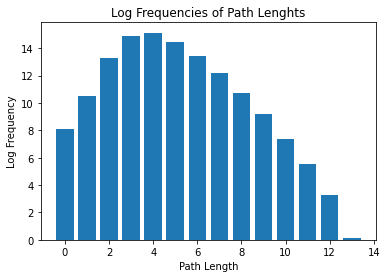

Counter({4: 3743759, 3: 2858173, 5: 1845025, 6: 680539, 2: 609545, 7: 197321, 8: 47043, 1: 36906, 9: 9886, 0: 3214, 10: 1576, 11: 248, 12: 27, 13: 1})


In [16]:
count = Counter(all_paths_len)
plt.bar(count.keys(),[math.log(i+0.1) for i in count.values()])
plt.title("Log Frequencies of Path Lenghts")
plt.xlabel("Path Length")
plt.ylabel("Log Frequency")
plt.show()
print(count)

### Centrality

In [17]:
# Closeness
nx.closeness_centrality(G)

{0: 0.224592339092669,
 2: 0.22467311027122494,
 3: 0.22467311027122494,
 1: 0.22464079482925858,
 4: 0.2907325253258415,
 5: 0.224592339092669,
 2250: 0.2246084886820192,
 2256: 0.2245761918254972,
 2251: 0.2245761918254972,
 2254: 0.2245761918254972,
 2253: 0.22456004688000292,
 2243: 0.2245761918254972,
 2246: 0.2245761918254972,
 2245: 0.224592339092669,
 2255: 0.22612062053719706,
 1610: 0.32970553642609673,
 2244: 0.224592339092669,
 2247: 0.2245761918254972,
 2241: 0.224592339092669,
 2135: 0.28752119404462817,
 2242: 0.22454390425568546,
 1612: 0.28818435760686784,
 1951: 0.30095676385979775,
 2048: 0.24955103076622517,
 1485: 0.3741322616002923,
 2248: 0.2245761918254972,
 2249: 0.22454390425568546,
 1115: 0.3341853270675982,
 903: 0.3035597912634442,
 1058: 0.3774323649227695,
 1607: 0.354796711960568,
 1639: 0.3389355742296919,
 2257: 0.22454390425568546,
 6: 0.21171412851435817,
 7: 0.24445376835974647,
 2260: 0.1959617473087102,
 2261: 0.1743486409969212,
 2264: 0.17432918

In [24]:
#betweenness centrality
#in and out degree centrality

#Multigrap = paralell edges between nodes
#MultiDigraph = paralell edges between nodes that are directed
#Digraph = only 1 edge between nodes and it is directed
G2 = nx.DiGraph(G)  #making the multiDigraph into only a directed graph 
deg_centrality = nx.betweenness_centrality(G2)
in_deg_centrality = nx.in_degree_centrality(G2)
out_deg_centrality = nx.out_degree_centrality(G2)

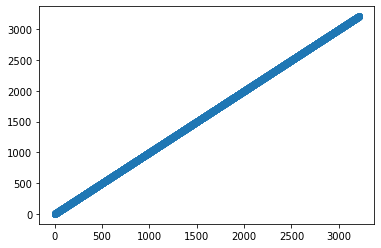

In [32]:
plt.figure()
plt.scatter(list(in_deg_centrality), list(out_deg_centrality))
plt.show()

In [36]:
import matplotlib.colors as mcolors

In [42]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [43]:
draw(G2, dpos, nx.in_degree_centrality(G2), 'DiGraph Degree Centrality')

NameError: name 'dpos' is not defined

In [26]:
#global reaching centality
nx.global_reaching_centrality(G2)

0.015025811825577145

### Community discovery

In [20]:
#make the graph undirected
undirected_G = G.to_undirected()

#Find the best partitioning
partition = community_louvain.best_partition(undirected_G)
print(partition)

#Draw the graph
pos = nx.spring_layout(undirected_G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                    cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(undirected_G, pos, alpha=0.5)
plt.show()

{0: 0, 2: 0, 3: 0, 1: 0, 4: 0, 5: 0, 2250: 0, 2256: 0, 2251: 0, 2254: 0, 2253: 0, 2243: 0, 2246: 0, 2245: 0, 2255: 0, 1610: 0, 2244: 0, 2247: 0, 2241: 0, 2135: 1, 2242: 0, 1612: 0, 1951: 0, 2048: 0, 1485: 1, 2248: 0, 2249: 0, 1115: 1, 903: 0, 1058: 1, 1607: 0, 1639: 0, 2257: 0, 6: 2, 7: 2, 2260: 2, 2261: 2, 2264: 2, 8: 2, 1988: 2, 2266: 2, 2262: 2, 13: 3, 14: 2, 295: 3, 1989: 2, 9: 2, 2265: 2, 10: 2, 11: 2, 12: 2, 218: 3, 308: 3, 315: 3, 282: 3, 368: 3, 294: 3, 1699: 4, 184: 3, 628: 3, 1853: 4, 1721: 4, 191: 3, 270: 3, 1829: 4, 1870: 4, 253: 3, 255: 3, 242: 3, 196: 3, 1754: 4, 2115: 4, 31: 4, 125: 4, 758: 3, 245: 3, 640: 3, 271: 3, 247: 3, 566: 3, 188: 3, 15: 4, 73: 4, 80: 4, 87: 4, 16: 4, 2288: 4, 121: 4, 122: 4, 17: 4, 89: 4, 124: 4, 65: 4, 99: 4, 18: 4, 46: 4, 130: 4, 19: 6, 2289: 6, 2326: 6, 79: 6, 90: 6, 20: 4, 71: 4, 97: 4, 3044: 4, 21: 4, 113: 4, 22: 6, 26: 6, 118: 6, 126: 6, 44: 6, 23: 4, 24: 4, 25: 4, 48: 4, 43: 6, 27: 6, 34: 6, 49: 6, 28: 6, 84: 6, 29: 4, 30: 4, 115: 4, 111: 

AttributeError: module 'branca.colormap' has no attribute 'get_cmap'

### Power law

Calculating best minimal value for power law fit
-5.562512674077134 0.029117724710571603


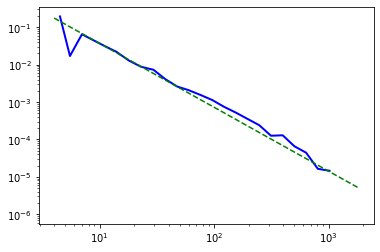

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
fit = powerlaw.Fit(degree_sequence)
fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
R, p = fit.distribution_compare('power_law', 'lognormal')
print (R, p)

### Visualization of the Network

In [ ]:
#66771
degree = [tup[1] for tup in sorted(G.degree)]
pd_nodes['degree'] =  degree #new
pd_nodes[' longitude'] = pd_nodes[' longitude'].astype(float)
pd_nodes[' latitude'] = pd_nodes[' latitude'].astype(float)

'''Dictionary with all the indexes of airports and their geographical placement'''
# i[1][0] = Index (Used to make the edges)
# i[1][7] = latitude
# i[1][8] = longitude
# i[1][9] = log degree

IDs = dict()
for i in pd_nodes.iterrows():
    ID = i[1][0]
    latitude = i[1][7]
    longitude = i[1][8]
    IDs[ID] = [latitude, longitude]

nodeDict = dict(G.nodes(data=True))
display(pd_nodes)

,# index,id,name,city,country,IATA/FAA,ICAO,latitude,longitude,altitude,timezone,DST,_pos,degree
0,0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,"array([6.29268027, 1.37900375])",10
1,1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,"array([6.30735453, 1.39906658])",16
2,2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,"array([6.3014785 , 1.38535133])",22
3,3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,"array([6.27849235, 1.39511825])",22
4,4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,"array([6.23308524, 1.34013967])",95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3209,11290,Kongolo Airport,Kongolo,Congo (Kinshasa),KOO,FZRQ,-5.394440,26.990000,1850,1.0,U,"array([5.5164688 , 1.37876336])",2
3210,3210,11436,Tarko-Sale Airport,Tarko-Sale,Russia,TQL,USDS,64.930801,77.818100,82,5.0,U,"array([5.87627232, 1.43157964])",2
3211,3211,11473,Jinchuan Airport,Jinchuan,China,JIC,ZLJC,38.542222,102.348333,4740,8.0,U,"array([6.169881 , 1.28830756])",12
3212,3212,11498,Alashankou Bole (Bortala) airport,Bole,China,BPL,ZWAX,44.895000,82.300000,1253,8.0,N,"array([6.07268073, 1.40575676])",2


In [ ]:
degrees = np.array(sorted([(G.degree(n)) for n in G.nodes()]))
max_degree = max(degrees)
min_degree = min(degrees)
median_degree = np.percentile(degrees, 50)
first_percentile = np.percentile(degrees, 25)
third_percentile = np.percentile(degrees, 75)

In [ ]:
points = np.vstack((pd_nodes[' latitude'], pd_nodes[' longitude'], pd_nodes['degree'] )).T
edges = np.vstack((pd_edges['# source'], pd_edges[' target'])).T
edges = np.delete(edges, -1, 0)

centroid = list(MultiPoint(points).centroid.coords)[0]

m = folium.Map()

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'yellow', 'orange', 'red'],
                             index=[min_degree, first_percentile, median_degree, third_percentile,max_degree],vmin=1,vmax=1800)
colormap.add_to(m)

for point in range(len(points)):
    folium.CircleMarker([points[point][0], points[point][1]], fill = True, fill_opacity = 0.1, radius =0.1 , color = colormap(points[point][2])).add_to(m)



"""
for edge in range(10000):#smaller value for sake of deepnote
    edge+=20000 ##accessing different slices of data as not in random order
    attr = {"font-weight": "bold", "font-size": "24"}
    source = IDs[edges[edge][0]]
    target = IDs[edges[edge][1]]
    #plane_line = folium.PolyLine([source,target], weight=1,color="black").add_to(m)
    #plugins.PolyLineTextPath(plane_line, "\u2708", repeat=True, offset=8, attributes=attr ).add_to(m)
    folium.PolyLine([source,target],weight=1,color="blue", opacity = 0.025, smooth_factor = 1 ).add_to(m)
"""
m

## Other Stuff

In [ ]:
#plane types explored 
equipment=[]
for i in pd_edges[" equipment"]:
    possible=str(i).split()
    for j in possible:
        equipment.append(j)
unique_equipment_count=Counter(equipment)
unique_equipment=pd.DataFrame(set(equipment))
print("Amount of each plane type",unique_equipment_count)
print("Unique plane types",set(equipment))
#print(Counter(pd_edges[" equipment"])) nope


Amount of each plane type Counter({'320': 15400, '738': 10344, '319': 7847, '321': 3662, '73H': 3343, '737': 2753, '73W': 2492, 'CRJ': 2224, 'E90': 1968, 'AT7': 1595, '333': 1585, '73G': 1584, '332': 1439, 'DH4': 1387, '733': 1283, '763': 1183, 'CR7': 1161, '757': 1069, 'CR9': 1011, 'ER4': 989, 'ERJ': 947, '777': 945, '77W': 908, '330': 903, '739': 868, 'E70': 864, 'DH8': 785, 'M88': 725, '735': 705, 'E75': 701, 'M80': 656, '772': 633, 'ATR': 626, '73C': 623, '717': 614, '752': 604, '744': 599, '100': 590, '343': 490, 'DH3': 484, 'SF3': 475, '767': 461, '734': 460, 'CR2': 458, 'E95': 457, 'M90': 416, 'ERD': 415, '32S': 383, '773': 370, '736': 364, 'M83': 361, 'DHT': 354, '32A': 315, '75W': 311, 'DH1': 305, 'BEH': 290, '788': 287, 'AT4': 269, 'CNA': 266, 'CNC': 258, 'AT5': 256, '318': 253, 'BE1': 237, '310': 225, '346': 222, '388': 214, 'EM2': 214, '76W': 196, 'EMJ': 195, 'DH2': 187, 'F70': 175, 'AR1': 162, 'M82': 160, 'CRK': 159, '764': 153, '77L': 151, '73J': 145, '753': 143, 'F50': 1

In [ ]:
unique_equipment.to_csv("../network/planes.csv", sep='\t',index=False)

In [ ]:
#m = Basemap(projection='robin',lon_0=0,resolution='l')
#m.drawcountries(linewidth = 0.5)
#m.fillcontinents(color='white',lake_color='white')
#m.drawcoastlines(linewidth=0.5)

In [ ]:
in_degrees=[]
out_degrees=[]
for node in G.nodes():
    in_degrees.append(G.in_degree(node))
    out_degrees.append(G.out_degree(node))

In [ ]:
max_occurances=Counter(maxinout)
min_occurances=Counter(mininout)

In [ ]:
min_occurances[0]#could this cause issues?

33

In [ ]:
def find_cap(G,per_extra=0.25):
    assert per_extra<=1 and per_extra>=0, "per_extra is a probability please enter a value from 1 to 0"
    cap=["na" for i in G.nodes()]
    for node in G.nodes():
        cap[node]=math.floor(mininout[node]+mininout[node]*per_extra)
    return cap

(array([2.000e+00, 1.100e+01, 4.400e+01, 3.052e+03, 8.900e+01, 8.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([-12. ,  -8.7,  -5.4,  -2.1,   1.2,   4.5,   7.8,  11.1,  14.4,
         17.7,  21. ]),
 <BarContainer object of 10 artists>)

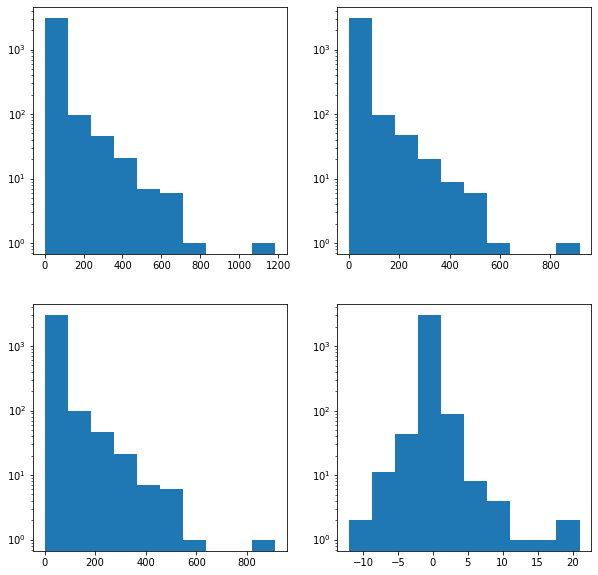

In [ ]:
inminout=np.array(in_degrees)-np.array(out_degrees)
maxinout=np.maximum(np.array(in_degrees),np.array(out_degrees))
mininout=np.minimum(np.array(in_degrees),np.array(out_degrees))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

ax[0,0].hist(find_cap(G,per_extra=0.3),log=True)
ax[1,0].hist(mininout,log=True)
ax[0,1].hist(maxinout,log=True)
ax[1,1].hist(inminout,log=True) #most airposts have similar in and out degrees as is to be expecte

## Distance from airport to airport

In [ ]:
def distance(point1, point2):
    return geopy.distance.distance(point1, point2).km

In [ ]:
# Testing the distance formula.
point1 = [pd_nodes[' latitude'][0], pd_nodes[' longitude'][0]]
point2 = [pd_nodes[' latitude'][1], pd_nodes[' longitude'][1]]

distance(point1, point2)

106.24895852093681

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30c69275-ad4c-4319-be77-065d0edffda8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>